In [390]:
import pandas as pd 
import pandas_profiling as pp 
aguadataframe = pd.read_csv('Calidad_de_agua_2022.csv',delimiter = ';')
aguadataframe
aguadataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   orden                    168 non-null    int64 
 1   sitios                   168 non-null    object
 2   codigo                   168 non-null    object
 3   fecha                    168 non-null    object
 4   año                      168 non-null    object
 5   campaña                  168 non-null    object
 6   tem_agua                 168 non-null    object
 7   tem_aire                 166 non-null    object
 8   od                       168 non-null    object
 9   ph                       168 non-null    object
 10  olores                   168 non-null    object
 11  color                    168 non-null    object
 12  espumas                  168 non-null    object
 13  mat_susp                 168 non-null    object
 14  colif_fecales_ufc_100ml  167 non-null    o

viendo la informacion del dataset, se puede ver que hay algunas columnas que contienen valores nulos (informacion para un posterior analisis) y ademas que todas las columnas son de tipo objet lo cual nos da un indicio de que algunas columnas vamos a tener que transformarlas y cambiarlas de tipo. 

In [391]:
aguadataframe = aguadataframe.drop(columns='orden')
aguadataframe = aguadataframe.drop(columns='año')
aguadataframe = aguadataframe.drop(columns='fecha')
aguadataframe = aguadataframe.drop(columns='cd_total_mg_l')
aguadataframe = aguadataframe.drop(columns='calidad_de_agua')
aguadataframe = aguadataframe.drop(columns='hidr_deriv_petr_ug_l')
aguadataframe = aguadataframe.drop(columns='codigo')
aguadataframe = aguadataframe.drop(columns='sitios')

In [392]:
aguadataframe1 = aguadataframe.copy()
aguadataframe1 = aguadataframe1.replace({"no se midió": pd.NA,
                                         "no midieron este día": pd.NA,
                                         "no se determinó": pd.NA,
                                         "no midio la sonda": pd.NA})
aguadataframe1 = aguadataframe1.dropna(thresh=15)

In [393]:
columnas_numericas=['tem_agua', 'tem_aire', 'od', 'ph','turbiedad_ntu','ica']
aguadataframe1[columnas_numericas]=aguadataframe[columnas_numericas].replace(',', '.', regex=True).apply(pd.to_numeric, errors='coerce')


In [394]:
boolean_columns = ['espumas', 'olores', 'color', 'mat_susp']
for col in boolean_columns:
    aguadataframe1[col] = aguadataframe1[col].replace({'Presencia': True,
                                                       'Ausencia': False,
                                                       'ausencia': False,
                                                       'Ausente': False,
                                                       }).astype(bool)

C:\Users\court\AppData\Local\Temp\ipykernel_5492\1186107394.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aguadataframe1[col] = aguadataframe1[col].replace({'Presencia': True,
C:\Users\court\AppData\Local\Temp\ipykernel_5492\1186107394.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aguadataframe1[col] = aguadataframe1[col].replace({'Presencia': True,
C:\Users\court\AppData\Local\Temp\ipykernel_5492\1186107394.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To

In [395]:
for col in ['cr_total_mg_l', 'clorofila_a_ug_l', 'microcistina_ug_l','nitrato_mg_l','nh4_mg_l','p_total_l_mg_l',
            'fosf_ortofos_mg_l','dbo_mg_l','dqo_mg_l','enteroc_ufc_100ml','escher_coli_ufc_100ml','colif_fecales_ufc_100ml']:  # Ajustá con el nombre de tus columnas
    aguadataframe1[col] = aguadataframe1[col].str.replace(r'^\s*<\s*', '', regex=True)  # Elimina "<" o " <" al inicio
    aguadataframe1[col] = pd.to_numeric(aguadataframe1[col], errors='coerce')  # Convierte a numérico

In [396]:
aguadataframe1 = pd.get_dummies(aguadataframe1, columns=['campaña'])

In [397]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
columnas_numericas = aguadataframe1.select_dtypes(include='number')
aguadataframe1[columnas_numericas.columns] = imputer.fit_transform(columnas_numericas).round(3)

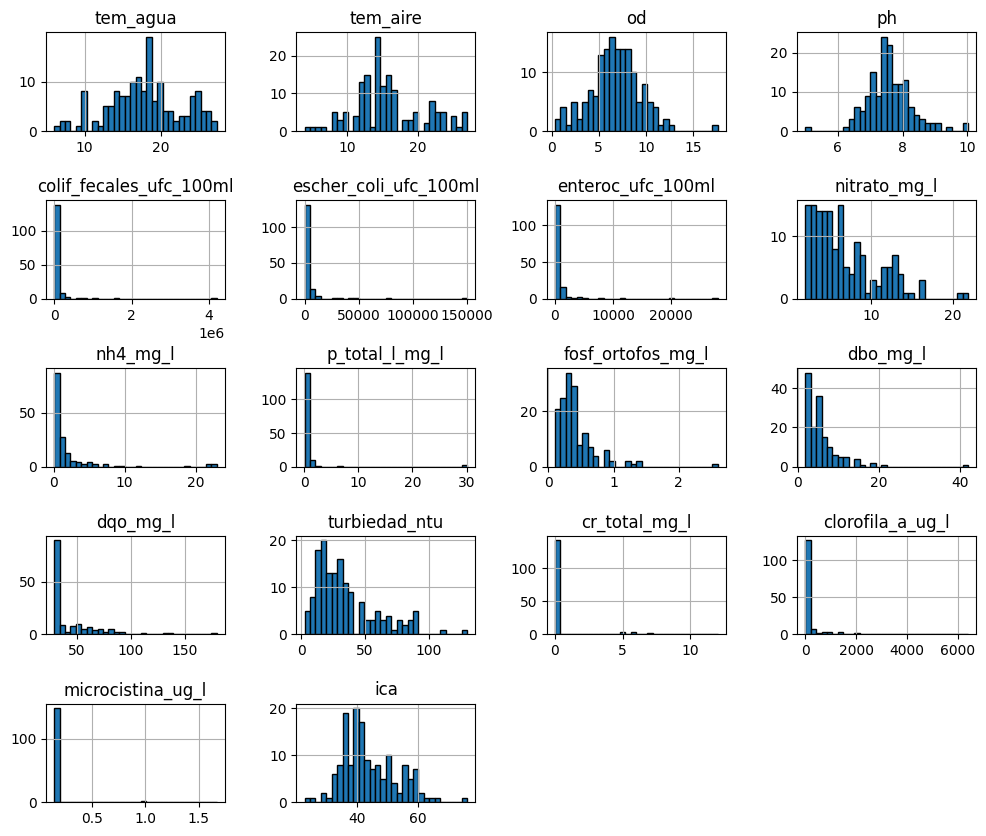

In [398]:
import matplotlib.pyplot as plt
%matplotlib inline
aguadataframe1.hist(figsize=(12,10),bins=30,edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

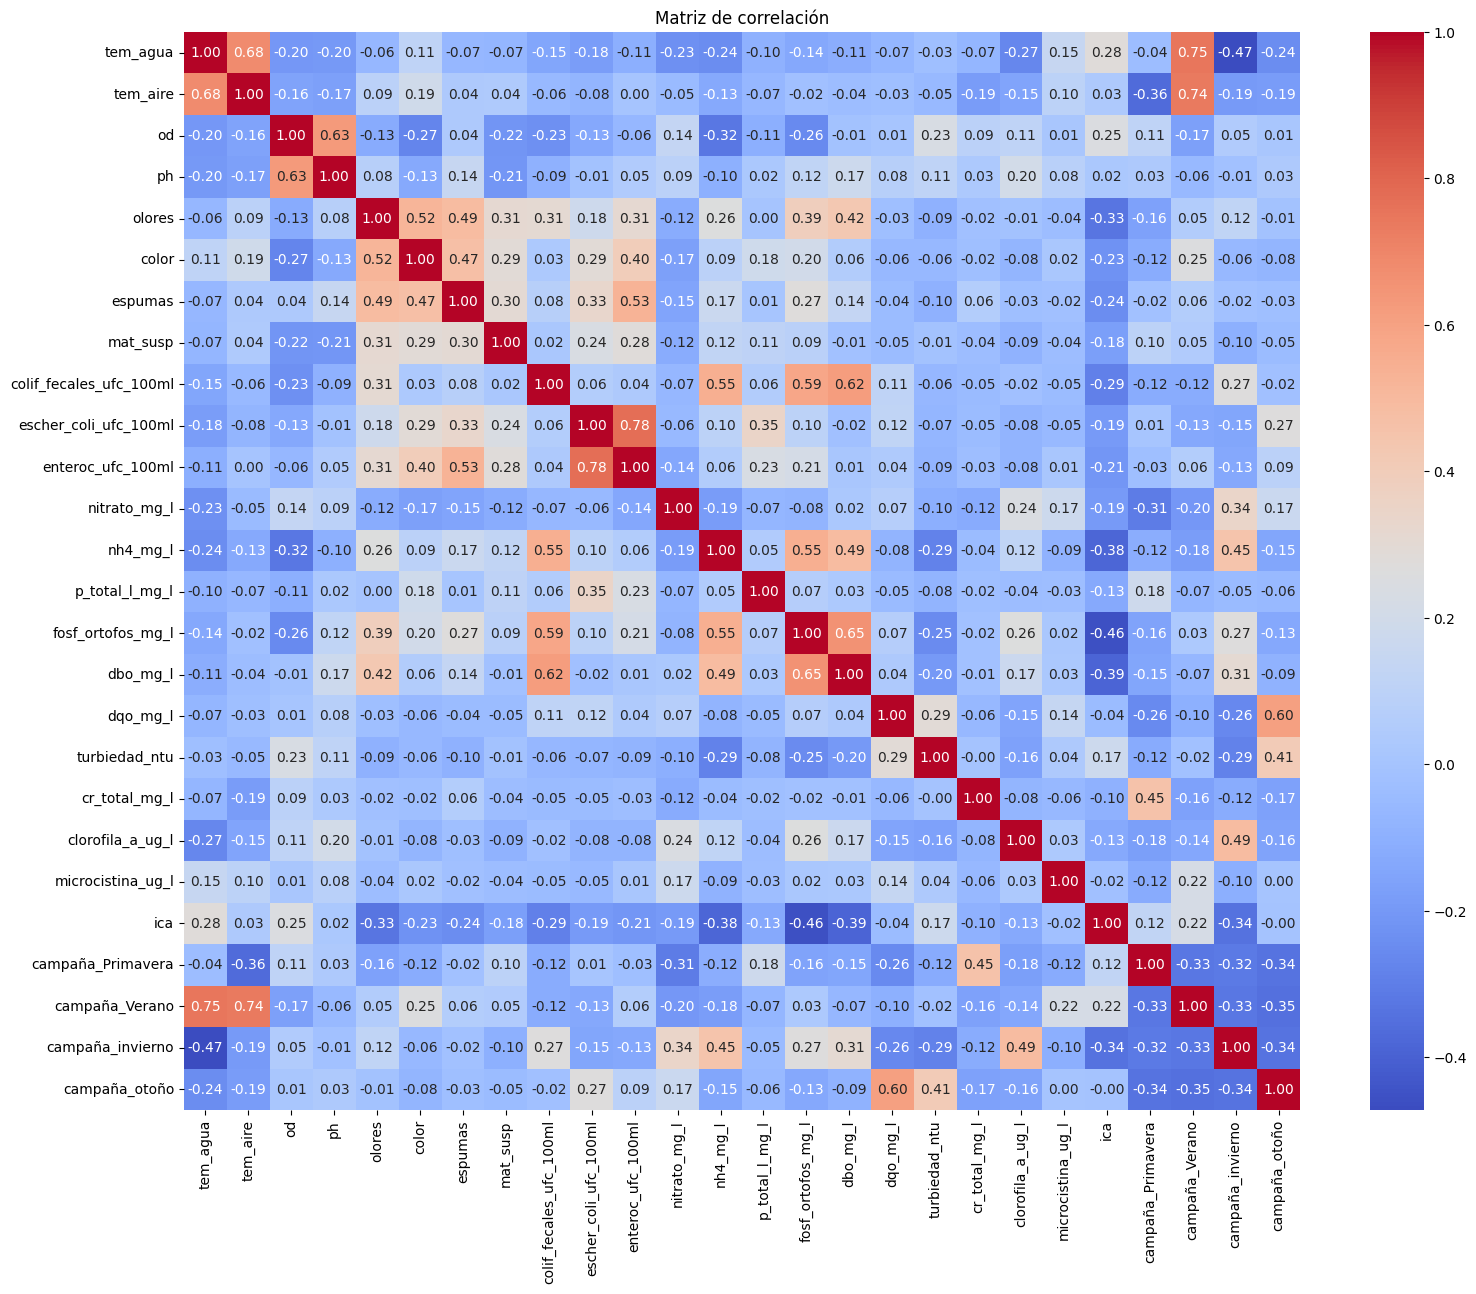

In [399]:
import seaborn as sns

plt.figure(figsize=(18,14))
sns.heatmap(aguadataframe1.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación')
plt.show()

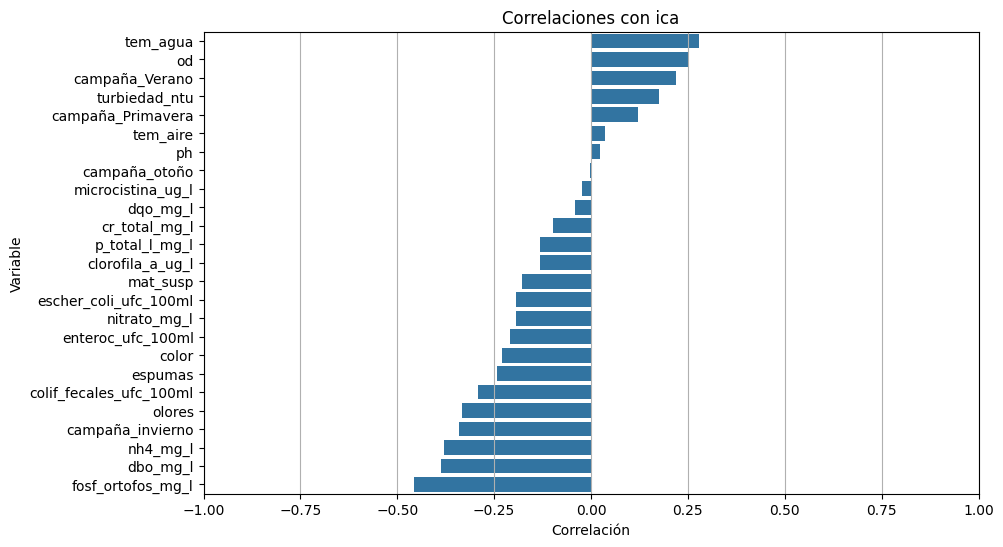

In [400]:
ica_correlaciones = aguadataframe1.corr()['ica'].drop('ica')
correlaciones_ordenadas = ica_correlaciones.sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.grid(True)
sns.barplot(x=correlaciones_ordenadas.values, y=correlaciones_ordenadas.index)
plt.title('Correlaciones con ica')
plt.xlabel('Correlación')
plt.ylabel('Variable')
plt.xlim([-1,1])
plt.show()

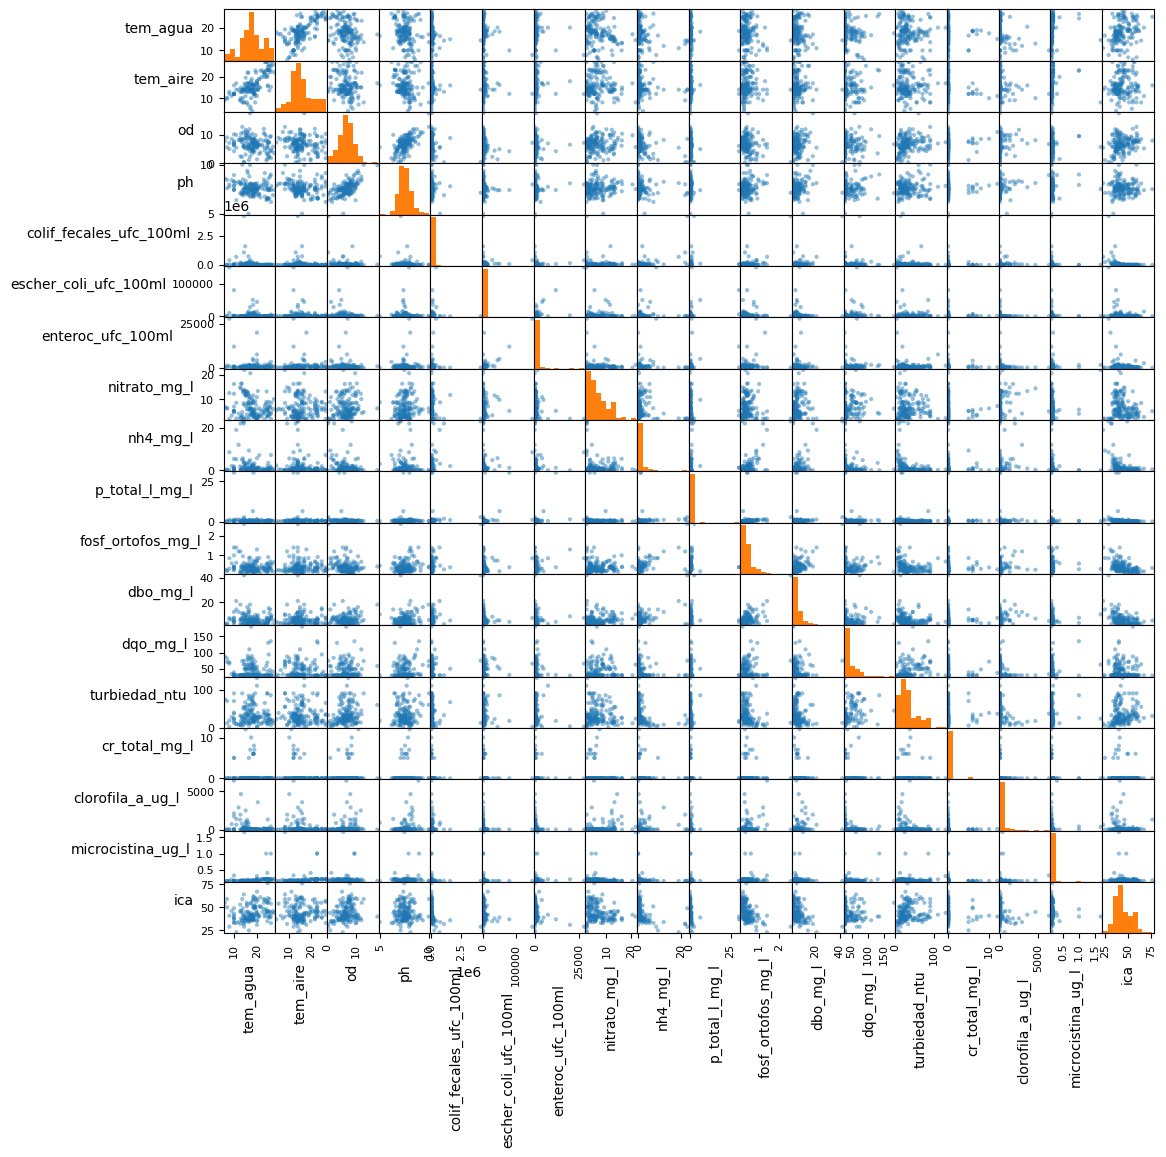

In [401]:
numeric_cols = aguadataframe1.select_dtypes(include=['number'])

# Crear el scatter matrix
axs = pd.plotting.scatter_matrix(numeric_cols, figsize=(12, 12), alpha=0.47, hist_kwds={'color':'#ff7f0e'})
# la mostramos por pantalla
# acomodamos la orientación del contenido de los ejes
for i in range(len(numeric_cols.columns)):
  for j in range(len(numeric_cols.columns)):
    ax=axs[i,j]
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.show()

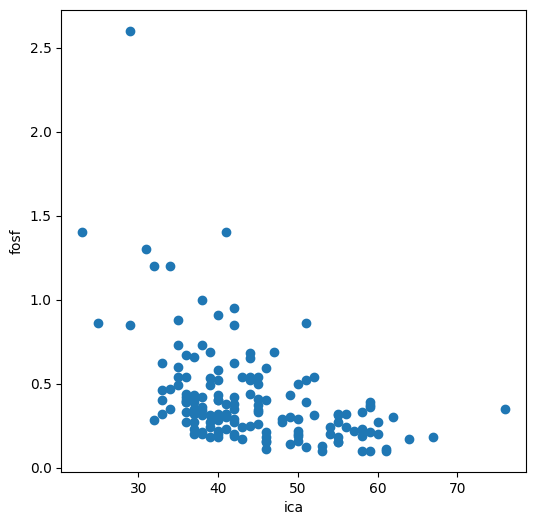

In [402]:
plt.figure(figsize=(6,6))
plt.scatter(aguadataframe1['ica'],aguadataframe1['fosf_ortofos_mg_l'])

plt.xlabel('ica')
plt.ylabel('fosf')
plt.show()

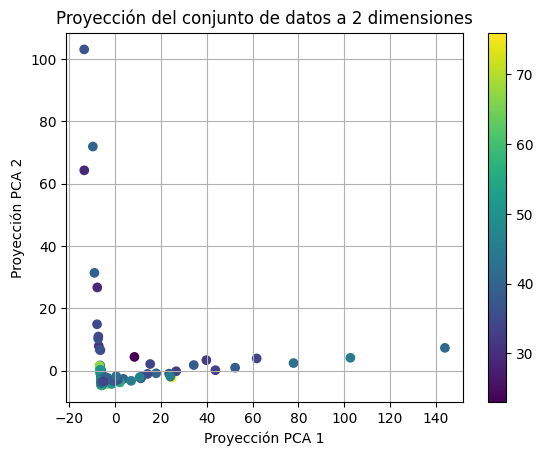

In [403]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

x = aguadataframe1.select_dtypes(include='number')

x.drop('ica',axis=1)

scaler = RobustScaler()

x_escalada = scaler.fit_transform(x)

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_escalada)

plt.scatter(x_pca[:,0], x_pca[:,1], c=aguadataframe1['ica'], cmap = 'viridis')
plt.grid(True)
#plt.xlim(-7,-5)
#plt.ylim(-5,5)
plt.xlabel('Proyección PCA 1')
plt.ylabel('Proyección PCA 2')
plt.title('Proyección del conjunto de datos a 2 dimensiones')
plt.colorbar()
plt.show()

Before t-SNE: (154, 18)
After t-SNE: (154, 2)


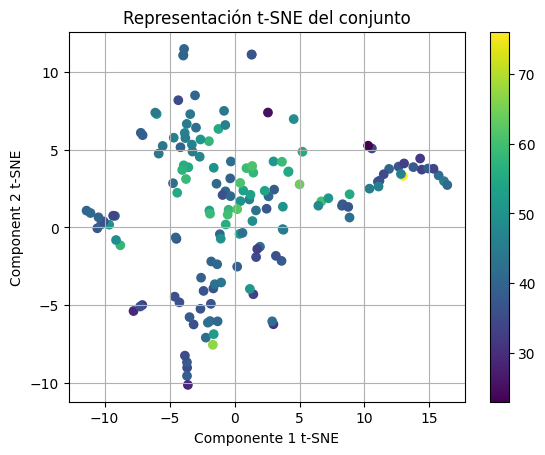

In [404]:
from sklearn.manifold import TSNE

# creamos el objeto, lo fitteamos en nuestros datos y lo aplicamos sobre esos mismos
#X_tsne = TSNE(n_components=2).fit_transform(X_train_stand) # sin random state
X_tsne = TSNE(n_components=2, random_state=10).fit_transform(x_escalada)  # con random state
# imprimimos los tamaños antes y después
print('Before t-SNE: {}'.format(x_escalada.shape))
print('After t-SNE: {}'.format(X_tsne.shape))

# graficamos los datos, el color de cada punto representa el valor de la casa
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=aguadataframe1["ica"], cmap='viridis')
plt.grid(True)
plt.xlabel('Componente 1 t-SNE')
plt.ylabel('Component 2 t-SNE')
plt.title('Representación t-SNE del conjunto')
plt.colorbar()
plt.show()

c:\Users\court\Documents\TPEFundamentos\PracticoEspecialGrupo14\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Antes de UMAP: (154, 18)
Después de UMAP: (154, 2)


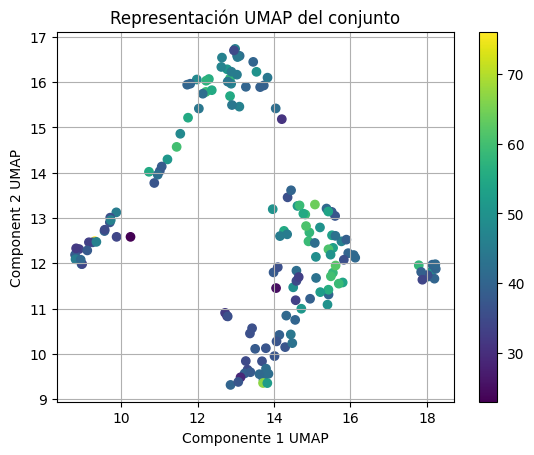

In [405]:
import umap.umap_ as umap

# creamos el objeto, lo fitteamos en nuestros datos y lo aplicamos sobre esos mismos
X_umap = umap.UMAP(n_components=2, random_state=10).fit_transform(x_escalada)
# imprimimos los tamaños antes y después
print('Antes de UMAP: {}'.format(x_escalada.shape))
print('Después de UMAP: {}'.format(X_umap.shape))

# graficamos los datos, el color de cada punto representa el valor de la casa
plt.scatter(X_umap[:,0], X_umap[:,1], c=aguadataframe1["ica"], cmap='viridis')
plt.grid(True)
plt.xlabel('Componente 1 UMAP')
plt.ylabel('Component 2 UMAP')
plt.title('Representación UMAP del conjunto')
plt.colorbar()
plt.show()

In [406]:
aguadataframe1.to_csv('aguitaFRESCA.csv')